# **Przygotowano**
Jakub Matłacz <br>
Kamil Trysiński

# 🙋 **TODO**

# 🔥 **Importy**

In [1]:
from our_library.our_reusable_methods import *
from our_library.plot_learning_curve import *

import pandas as pd
import seaborn as sns
import itertools
from itertools import chain

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,Lars
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split,HalvingGridSearchCV,HalvingRandomSearchCV,GridSearchCV,learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

# 🚀 **Tematyka projektu**
1. Stworzenie modelu regresji do przewidywania ilości spożywanego przez młodzież alkoholu zależnie od czynników środowiskowych. Tak wyuczony model, będący w stanie rozpoznawać trend w danych, można będzie używać jako narzędzie do wyznaczania ryzyka problemu alkoholowego na podstawie czynników środowiskoych. 
2. Skorzystano ze zbioru [student-alcohol-consumption](https://data.world/data-society/student-alcohol-consumption)
3. Oryginalny zbiór zawiera dane z podziałem na szkoły i 2 tabele posiadają dane na temat ocen z matematyki oraz języka. Połączono obie tabelki w jedną i usunięto niepotrzebne kolumny. Zmienne opisywane to spożycie w tygodniu oraz w weekendy. Połączono obie zmienne w jedną we wspólny współczynnik patologicznego spożycia, gdzie picie w tygodniu będzie liczone z wyższą wagą. Wszelkie zmiany na danych oryginalnych opisano i wykonano w komórce w sekcji "Wstępne Przygotowanie Danych".

# 🌓 **Analiza Eksploracyjna**

# 🐇 **Wstępne Przygotowanie Danych**
Dane są tylko połączone w zbiór, który jest nam potrzebny, ale należy traktować je jako dane "oryginalne" czyli niepoddane normalizacji, czy innym inwazyjnym technikom. Jedyne co zrobiono to usunięto/połączono pewne kolumny, zamieniono atrybuty kategoryczne na ilościowe w celu umożliwienia dalszej analizy zbioru i uczenia modelu, zmieniono nazwy kolumn i posortowano w celu większej przejrzystości w dalszych wizualizacjach, zamieniono typy danych na int64, ponieważ wszystkie wartościo były całkowite (dane składają się z wielu atrybutów dobieranych przez człowieka w wyniku rozmowy z uczniem, więc są to pewne wskaźniki). Ponadto połączono picie w tygodniu i weekend we wspólny wskaźnik problemu alkoholowego z wyższą wagą dla picia w tygodniu.

In [2]:
# wczytanie zbioru i usunięcie niepotrzebnych nam kolumn
d1 = pd.read_csv("student-mat.csv")
d2 = pd.read_csv("student-por.csv")
# łączę obie tabelki w jedną
dataset = pd.concat([d1,d2], ignore_index=True)
# istnieje część wspólna obu tabelek więc usuwam kolumny niepotrzebne i z założenia różniące obie tabele i usuwam duplikaty, czyli wystąpienia tych samych uczniów
dataset = dataset.drop(columns=["G1","G2","G3","paid"]).drop_duplicates(ignore_index=True)
# zakładam, że picie w tygodniu 2.5 razy mocniej wskazuje na problem alkoholowy, ponieważ 5/2=2.5 co jest całkowicie arbitralnym wyborem
dataset['alc'] = 2.5 * dataset.Dalc + dataset.Walc
# usuwam kolejne zbędne kolumny
dataset = dataset.drop(columns=["school","Dalc","Walc"])
# prosta binaryzacja atrybutów tam gdzie to możliwe, 
# dobieram wartości tak, aby rosły wraz ze stopniem depresji
for feature,value in zip(['sex','address','famsize','Pstatus'],['F','R','LE3','T']):
    dataset[feature] = dataset[feature].apply(lambda x:0 if x==value else 1)
# zamiast pisać ręcznie dla każdej jak powyżej
yes_no_columns = ['schoolsup','famsup','activities','nursery','higher','internet','romantic']
for c in yes_no_columns:
    dataset[c] = dataset[c].apply(lambda x:0 if x=="no" else 1)
# binaryzacja techniką one-hot-encode atrybytów kategorycznych
features_to_encode = ['Mjob','Fjob','reason','guardian']
encoder = OneHotEncoder()
results = encoder.fit_transform(dataset.loc[:,features_to_encode])
# zamiana starych atr. kat. na nowe one-hot-y
dataset_without_categoricals = dataset.drop(columns=features_to_encode).reset_index().drop(columns=["index"])
encoded_categoricals = pd.DataFrame(results.toarray(), columns=encoder.get_feature_names(features_to_encode)).reset_index().drop(columns=["index"])
dataset = pd.concat([dataset_without_categoricals, encoded_categoricals], axis=1)
# zamiana typów danych na int64
dataset = dataset.convert_dtypes()
# zamiana nazw kolumn na lowercase
dataset.columns = [c.lower() for c in dataset.columns]
# zamiana kolejności kolumn na alfabetyczną
dataset = dataset[sorted(dataset.columns)]

# **Braki W Danych**

W zbiorze danych nie ma żadnych braków danych, żadnych niewypełnionych wartości cech.

In [3]:
dataset.isna().sum().sum()

0

# 📺 **Oglądanie Danych**

Najwięcej punktów oddalonych ma cecha "nieobecności" i trzeba było je przyciąć, aby nie popsuć widoczności wykresu. Inną opcją była zamiana skali na log ale uważam, że w tym przypadku nie miałoby to sensu, bo ciężko jest odczytać dokładne zakresy zmienności cech, które są dość małe. Naturalnie wiele atrybutów binarnych (powstałych z kategorycznych) ma zakres zmienności 0,1 bo przyjmuje tylko te 2 wartości. "Niezdania" mają sporo punktów oddalonych, co ma sens, bo to jedna z tych rzeczy, które na poziomie liceum dotykają tylko nielicznych uczniów. Tak samo "relacje rodzinne". Co ciekawe "czas wolny" ma punkt oddalony. Prawdopodobnie uczeń z dużą ilością zajęć dodatkowych. Dodatkowo warto wspomnieć, że skoro dane były pobierane przez nauczyciela od ucznia na podstawie rozmowy to na pewno są mocno zaszumione przez subiektywne odczucia ucznia odnośnie np. poziomu zdrowia czy relacji z rodziną. Ludzie mają tendencję do narzekania w tych sprawach co może niesłusznie pogarszać wyniki itp.

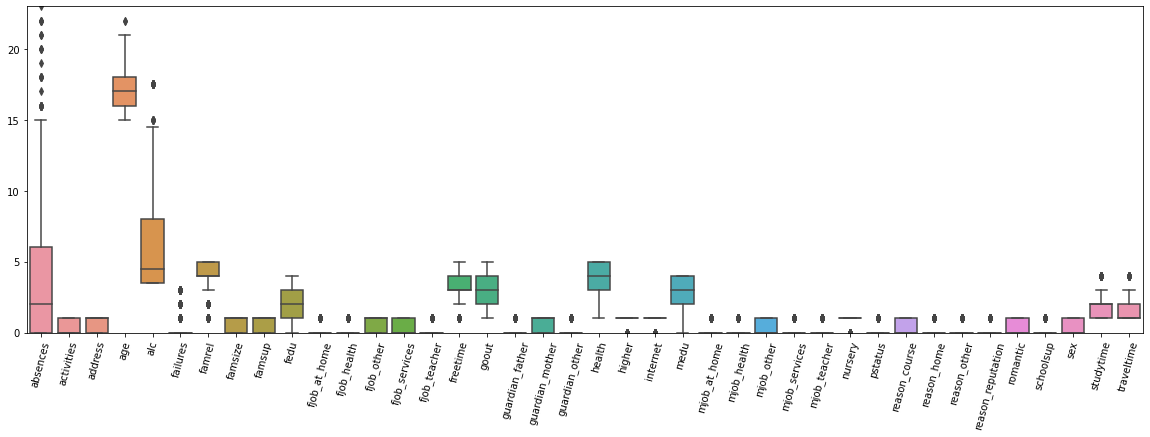

In [4]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=dataset)
ax.set_xticklabels(ax.get_xticklabels(),rotation=75)
# celowo ucinam punkty oddalone z wykresu
ax.set_ylim(0,23);
#ax.set_yscale('log')

Można powiedzieć, że zbiór jest niezbalansowany względem naszej zmiennej opisywanej (odpowiednik klasy w klasyfikacji). Wynik maksymalny to 17.5. Połowa osób ma wynik mniejszy od 4.5. Ćwierć osób ma wynik <4.5,8>. Tylko pozostałe ćwierć osób ma wynik wyższy niż 8. Jest to jednak zrozumiałe i na całe szczęście tylko nieliczni mają problem w badanej próbie.

count    959.000000
mean       6.094369
std        3.308938
min        3.500000
25%        3.500000
50%        4.500000
75%        8.000000
max       17.500000
Name: alc, dtype: float64


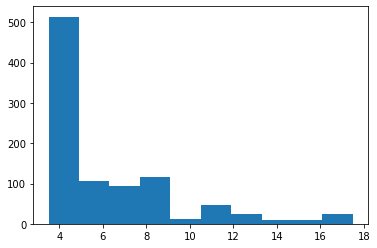

In [40]:
print(dataset.alc.describe())
plt.hist(dataset.alc);

Jak widać najwięcej punktów oddalonych mają cechy takie jak:
1. nieobecności - większość uczniów prawie nie ma nieobecności,
2. niezadania do następnej klasy - większości uczniów nigdy nie zdarzyło się niezdać do następnej klasy,
3. relacje rodzinne - większość uczniów ma dobre relace rodzinne.

Możliwe, że odchylenia od normy w tak ważnych dla rozwoju dziecka metrykach będą mieć spory wpływ na ryzyko alkoholowe.

Jak widać mamy około tysiąca obiektów w zbiorze. Zbiór naturlanie nie jest zbalsowany pod kątem zmiennej opisywanej "alc". Przyjmuje ona wartości z zakresu <3.5,17.5>. Wartości rosną wraz ze stopniem alkoholizmu. Tylko 25% uczniów pije więcej niż około połowa tego zakresu, czyli średni stopień problemu. Jeden uczeń (punkt oddalony) wyznacza górny limit skali stanowiąc dla nas naturalny punkt odniesienia (skala empiryczna).

In [6]:
# Obliczenia trwają bardzo długo dla takiej liczby atrybutów
# sns.pairplot(dataset)

Poniżej widać rozkłady wszystkich cech. Jak widać wiele z nich jest binarnych lub ogólniej dyskretnych.

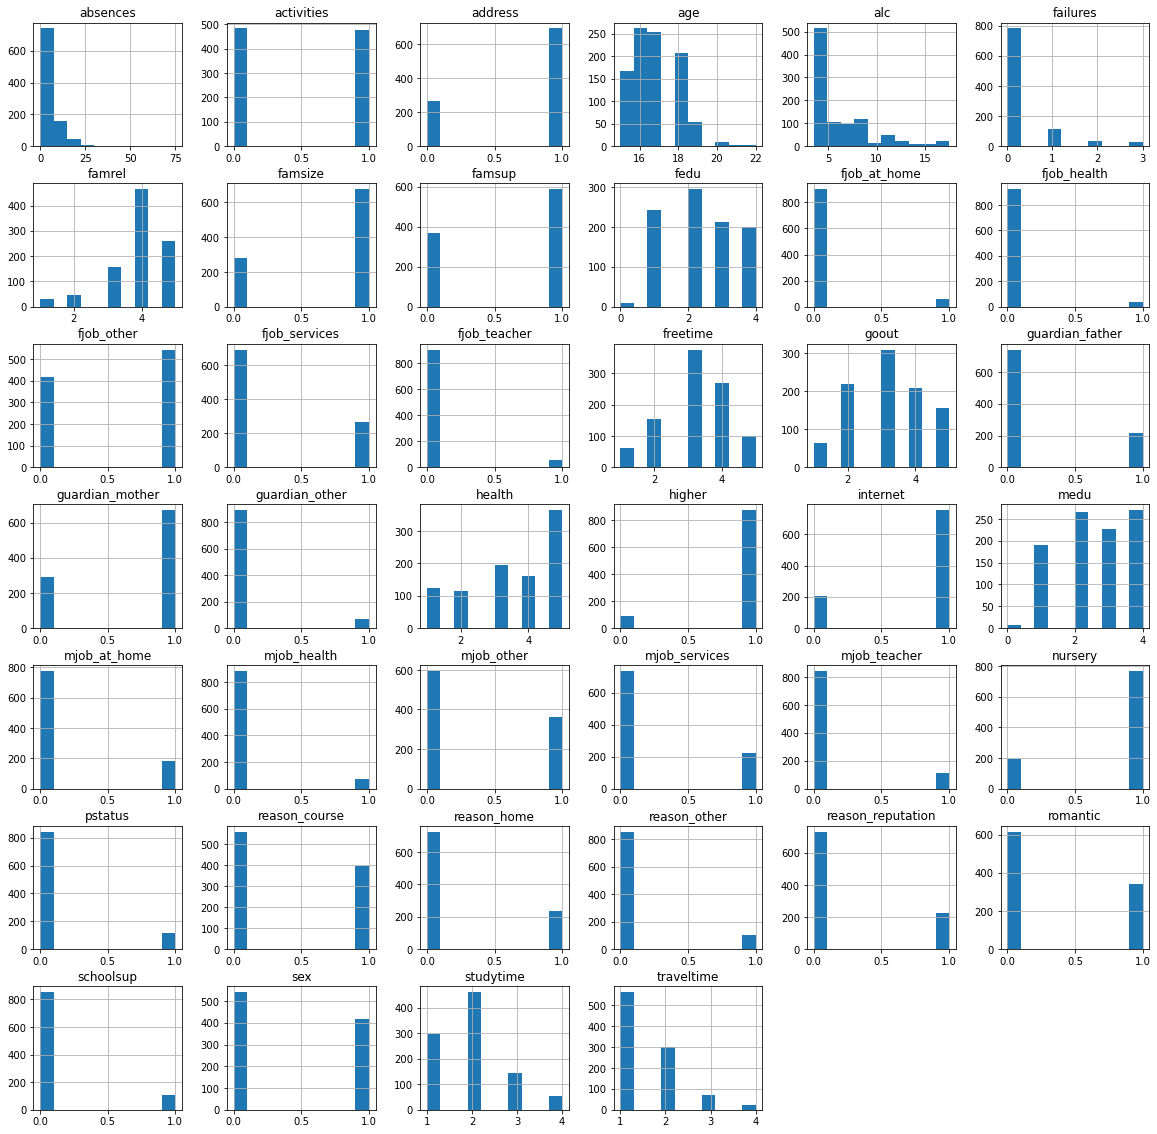

In [46]:
dataset.hist(figsize=(20,20));

# 🍀 **Korelacje Cech**

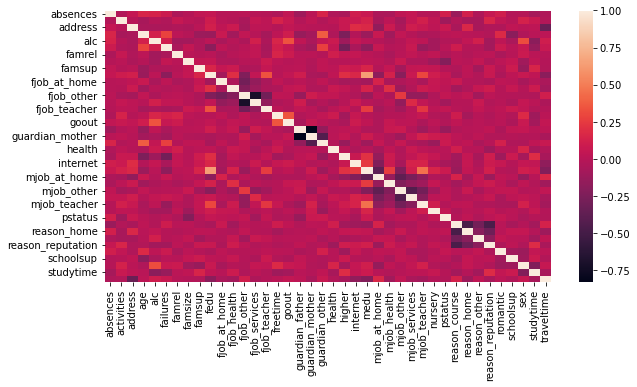

In [7]:
plt.figure(figsize=(10,5))
corr = dataset.corr()
sns.heatmap(data=corr);

In [8]:
corr_list = list(itertools.chain(*[[(r,c,corr.loc[r,c]) for r in corr.columns] for c in corr.columns]))
sorted_abs_corr_list = sorted(corr_list,key=lambda x:abs(x[2]), reverse=True)
sorted_abs_corr_list = list(filter(lambda x:x[0]!=x[1] and abs(x[2]) > 0.3, sorted_abs_corr_list))[::2]
pd.DataFrame(sorted_abs_corr_list, columns=['atr1','atr2','corr'])

,atr1,atr2,corr
0,guardian_mother,guardian_father,-0.830369
1,fjob_services,fjob_other,-0.711511
2,medu,fedu,0.637790
3,reason_home,reason_course,-0.477166
4,reason_reputation,reason_course,-0.467695
5,mjob_teacher,medu,0.450380
6,mjob_services,mjob_other,-0.430532
7,guardian_other,guardian_mother,-0.425006
8,mjob_at_home,medu,-0.380988
9,mjob_other,mjob_at_home,-0.379828


![title](https://miro.medium.com/max/932/1*Qz_gwy4ZaSZuOpl3IyO2HA.png)

Opis najbardziej znaczących korelacji:
- opieka ojca albo matki w rozwiedzionych parach
- edukacja matki i ojca
- praca nauczyciela i edukacja dla matek i ojców ale w mniejszym stopniu
- praca matki w domu, a wykształcenie
- tak zwany inny opiekun dla uczniów, których wiek jest nietypowo wysoki w szkole średniej (dom dziecka, etc.)
- wyjścia z domu, a alkohol i czas wolny
- czas podróży tym wyższy jeśli mieszkają poza miastem
- płeć męska i alkohol
- wybór szkoły ze względu na reputację kontra ze względu na wygodę czyli bliskość od domu

# 🌓 **Opracowanie Modelu Regresji**

# 📐 **Skalowanie Danych**

Wiele cech po wstępnym przetworzeniu jest binarnych one-hot-encode. Wprowadzono takie rozwiązanie w celu możliwie mocnego zrównania wpływu różnych wartości atrybutu kategorycznego na wynik. Jednak mimo to wciąż będzie on obecny w małym stopniu dlatego wartości cech binarnych rosną wraz z intucyjnym wpływem na depresję ucznia czyli np. mieszkanie na wsi = 0, w mieście = 1, bo na ogół w mieście ludzie czują się bardziej wyalienowani i samotni (jest to pewien bias z mojej strony, ale lepszy niż losowość). Aby zrównać wpływ wszystkich cech znormalizowano je do zakresu. Wybrano zakres <1,2> bo pozwala uniknąć problemów z małymi liczbami i dzieleniem przez zero w metrykach. Również dla cech z punktami oddalonymi, ponieważ oczywistym jest, że zbiór nie może być zbalansowany pod kątem ilości alkoholików w szkole (całe szczęście), więc punkty oddalone są bardzo cenne bo są to właśnie zachowania abnormalne mające ważny wpływ na wynik.

In [ ]:
X = dataset.drop(columns=['alc'])
y = dataset['alc']
# skalowanie minmax, nie wpływa na nasze atr. binarne, ale wyrównuje wpływ z pozostałymi atrybutami
scaler = MinMaxScaler(feature_range=(1,2))
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
# brak skalowania zmiennej opisywanej dał gorsze wyniki więc ją skaluję (jeśli nie to zakomentuj)
y = scaler.fit_transform(y.to_numpy().reshape(-1,1))
y = list(chain(*y.reshape(1,-1)))
# podział wyczyszczonego zbioru na części, wszystko robimy na treningowym (włącznie z walidacją), 
# a testowy dopiero na sam koniec dla już wybranego modelu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 👽 **Szukanie Modelu**
Przetestujemy następujące modele regresji:
- Multiple LinearRegression
- Multiple Polynomial Regression
- Ridge
- Lasso
- Elastic-Net
- SVR with kernel:

<ol>
<li>Poly</li>
<li>Linear</li>
<li>RBF</li>
</ol>

- Least Angle Regression

Na początku będę dobierał parametry na podstawie założonych apriori wartości pozostałych parametrów. Będzie to przypominać jedną iteracje prostej optymalizacji przestrzeni hiperparametrów (startującej w określonym wektorze początkowym hiperparametrów), ale z wieloma problemami (może dałoby się napisać algorytm takiej optymalizacji rozwiązując problem poruszania się po skośnych drogach w krajobrazie optymalizacyjnym, ale na chwilę obecną będzie to służyć pewnemu porównaniu). Wykresy pomogą mi później wybrać zakresy wartości do przeszukiwania kombinacji hp. Następnie porównam oba podejścia, ale pierwsze służy głównie stworzeniu pewnego zrozumienia doboru hp. 

Zdecydowano się użyć MAE, ponieważ jest częścią wbudowanych funkcji sklearn, natomiast wynikiem testowania będzie MAPE.

In [ ]:
# zapisanie najlepszych dobranych parametrów, modeli oraz wynikow testowania
models_parameters = []

# **Dummy Regressor**

In [ ]:
quantile_strategies = [{"strategy":"quantile", "quantile" : q} for q in np.arange(0,1,0.1)]
constant_strategies = [{"strategy":"constant", "constant":c} for c in np.arange(0,1,0.1)]
strategies = quantile_strategies + constant_strategies + [{"strategy":"mean"}]
dummy_errors = []

for s in strategies:
    dummy = DummyRegressor(**s)
    error,_ = test_model(dummy,X_train,y_train,X_test,y_test)
    dummy_errors.append((dummy,error))

In [ ]:
sorted(dummy_errors,key=lambda x:x[1])[:10]

Jak widać dla różnych dummy strategii mamy wyniki błędu MAPE w zakresie około 12-100%. Oznacza to, że nasz ostateczny model z całą pewnością musi być znacznie lepszy niż najniższa wartość dummy błędu. Najlepsze wyniki dummy są dla strategii przewidywania zawsze medianowego wyniku "alc". Oznacza to, że większość wartości w zbiorze testowym są bliskie medianie wartości ze zbioru treningowego.

#  **Wieloraka Regresja Liniowa**
Nie posiada żadnych hiperparametrów.

In [ ]:
model = LinearRegression()
score,train_score = test_model(model,X_train,y_train,X_test,y_test,silent=False)

In [ ]:
plot_learning_curve(
    estimator = LinearRegression(),
    title = "Learning Curves Multiple Linear Regression",
    X = X_train,
    y = y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20),
);

Jak widać wynik testowania jest tylko nieco lepszy niż dla najlepszego dummy modelu. Krzywa uczenia wskazuje nam, że wielkość zbioru treningowego jest dostateczna dla tego typu modelu (więcej się nie nauczy, nie zyska na większej ilości danych). Jest również skalowalny choć nie zyska dzięki temu na doładności.

# Wieloraka Regresja Wielomianowa

In [ ]:
model = LinearRegression()
errors = []
for degree in range(30):
    X_train_extended,X_test_extended = [extend_to_poly_features(X,degree) for X in [X_train,X_test]]
    error = test_model(model,X_train_extended,y_train,X_test_extended,y_test)
    errors.append(error)
plt.plot(errors)

In [ ]:
sorted(zip(range(50),errors),key=lambda x:x[1][0])[0]

Najlepszy model dla stopnia 0. Tylko trochę lepszy wynik niż dummy, czyli model się nie nadaje.

# Regresja Grzbietowa

In [ ]:
alpha, best_score, _,_ = plot_validation_curve(
    model = Ridge(random_state=1),
    model_name = "Ridge Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-2,5,20),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
model = Ridge(random_state=1,alpha=alpha)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"alpha" : alpha}
save_model("Ridge",parameters,model,score,models_parameters)

In [ ]:
plot_learning_curve(
    estimator = Ridge(random_state=1,alpha=alpha),
    title = "Learning Curves Ridge",
    X = X_train,
    y = y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

In [ ]:
model = Ridge(random_state=1, alpha=alpha).fit(X_train,y_train)
dict(sorted(zip(X_train.columns,model.coef_),key=lambda x:abs(x[1]),reverse=True))

Skalowalny i nie zyska zbyt wiele na zwiększeniu zbioru. Najmniej ważne są cechy takie jak
- chęć dalszego kształcenia,
- wsparcie rodziny (co brzmi dość dziwnie), 
- ilość wolnego czasu, 
- niezdania itp.

Najwyższy wpływ mają cechy:
- ilość wyjść (czy pije bo wychodzi czy wychodzi by się napić?),
- płeć (wcześniej podane wyższą liczbę płci mężczyzna),
- relacje rodzinne obniżają ryzyko,
- nieobecności podwyższają (lub świadczą o już istniejącym problemie), 
- wiek - starsi siłą rzeczy czują przyzwolenie do picia

# Regresja Lasso

In [ ]:
alpha, best_score, _,_ = plot_validation_curve(
    model = Lasso(random_state=1,positive=True),
    model_name = "Lasso Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-4,0,20),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
model = Lasso(random_state=1,positive=True,alpha=alpha)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"alpha" : alpha}
save_model("Lasso",parameters,model,score,models_parameters)

In [ ]:
plot_learning_curve(
    estimator = Lasso(random_state=1,positive=True,alpha=alpha),
    title = "Learning Curves Lasso",
    X = X_train,
    y = y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20),
);

In [ ]:
model = Lasso(random_state=1,positive=True,alpha=alpha).fit(X_train,y_train)
dict(sorted(zip(X_train.columns,model.coef_),key=lambda x:abs(x[1]),reverse=False))

Podobnie jak wyżej tylko wynik gorszy (taki sam jak dummy). Najwyższy wpływ mają te same cechy do w grzbietowej. 

# Elastic-Net
- alpha
- l1_ratio

In [ ]:
alpha, best_score, _,_ = plot_validation_curve(
    model = ElasticNet(random_state=1),
    model_name = f"ElasticNet Regression)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-4,0,20),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
l1_ratio, best_score, _,_ = plot_validation_curve(
    model = ElasticNet(random_state=1,alpha=alpha),
    model_name = f"ElasticNet Regression (alpha={alpha})",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,1.01,0.01),
    param_name = "l1_ratio",
    scoring = "neg_mean_absolute_error",
    xscale = "lin"
)

In [ ]:
model = ElasticNet(random_state=1,alpha=alpha,l1_ratio=l1_ratio)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"alpha" : alpha, "l1_ratio" : l1_ratio}
save_model("ElasticNet",parameters,model,score,models_parameters)

In [ ]:
plot_learning_curve(
    estimator = ElasticNet(random_state=1,alpha=alpha,l1_ratio=l1_ratio),
    title = "Learning Curves ElasticNet",
    X = X_train,
    y = y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20),
);

In [ ]:
# model = ElasticNet(random_state=1)

# param_grid = {"alpha": np.logspace(-6,2,50),
#               "l1_ratio": np.arange(0,1.01,0.01)}

# search = GridSearchCV(
#     model,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     verbose=2, 
#     n_jobs=8
# ).fit(X_train,y_train)

# print(search.best_params_)

# model = ElasticNet(random_state=1,**search.best_params_)
# score = test_model(model,X_train,y_train,X_test,y_test)

# print(score)

Podobnie jak ridge i lasso.

# SVM Z Jądrem Wielomianowym

- degree
- gamma
- C
- epsilon

In [ ]:
degree, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly"),
    model_name = "Poly SVR",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,30),
    param_name = "degree",
    scoring = "neg_mean_absolute_error",
    xscale = "lin"
)

In [ ]:
gamma, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly",degree=degree),
    model_name = f"Poly SVR (degree={degree})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-2,0,20),
    param_name = "gamma",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
C, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly",degree=degree,gamma=gamma),
    model_name = f"Poly SVR (degree={degree},gamma={gamma})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-3,1,20),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
epsilon, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly",degree=degree,gamma=gamma,C=C),
    model_name = f"Poly SVR (degree={degree},gamma={gamma},C={C})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,1,20),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
model = SVR(kernel="poly",degree=degree,gamma=gamma,C=C,epsilon=epsilon)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"degree":degree,"gamma":gamma,"C":C,"epsilon":epsilon}
save_model("SVR_poly",parameters,model,score,models_parameters)

In [ ]:
plot_learning_curve(
    estimator = SVR(kernel="poly",degree=degree,gamma=gamma,C=C,epsilon=epsilon),
    title = "Learning Curves SVR_poly",
    X = X_train,
    y = y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

Zdecydowanie lepsze wyniki niż dla klasycznej regresji. Spadek do błędu około 10%. Model zdecydowanie zyskałby na zwiększeniu zbioru uczącego. Jednak nie jest zbyt dobrze skalowalny (typowe dla SVMów).

In [ ]:
# model = SVR(kernel="poly")

# param_grid = {"degree": list(range(0,15)),
#               "gamma": np.logspace(-1.5,-0.5,20),
#               "C" : np.logspace(-0.5,0.5,20), 
#               "epsilon" : np.logspace(-5,-2,5)
#               }

# search = GridSearchCV(
#     model,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     verbose=2, 
#     n_jobs=8
# ).fit(X_train,y_train)

# print(search.best_params_)

# model = SVR(kernel="poly",**search.best_params_)
# score = test_model(model,X_train,y_train,X_test,y_test)

# print(score)

# SVM Z Jądrem Liniowym

In [ ]:
C, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="linear"),
    model_name = "Linear SVR",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-6,1,20),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
epsilon, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="linear",C=C),
    model_name = f"Linear SVR (C={C})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-4,1,20),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
model = SVR(kernel="linear",C=C,epsilon=epsilon)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"C":C,"epsilon":epsilon}
save_model("SVR_linear",parameters,model,score,models_parameters)

In [ ]:
plot_learning_curve(
    estimator = SVR(kernel="linear",C=C,epsilon=epsilon),
    title = "Learning Curves SVR_linear",
    X = X_train,
    y = y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

Wynik znacznie gorszy z jądrem liniowym, nie zyska na zwiększeniu zbiory uczącego i źle skalowany. Już lepszy byłby zwykły liniowy.

In [ ]:
# model = SVR(kernel="linear")

# param_grid = {"C" : np.logspace(-3,0,40), 
#               "epsilon" : np.logspace(-4,-1,40)}

# search = GridSearchCV(
#     model,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     verbose=2, 
#     n_jobs=8
# ).fit(X_train,y_train)

# print(search.best_params_)

# model = SVR(kernel="linear",**search.best_params_)
# score = test_model(model,X_train,y_train,X_test,y_test)

# print(score)

# SVM Z Jądrem RBF

In [ ]:
gamma, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="rbf"),
    model_name = "RBF SVR",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,20),
    param_name = "gamma",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
C, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=gamma),
    model_name = f"RBF SVR (gamma={gamma})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,3,20),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
epsilon, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=gamma,C=C),
    model_name = f"RBF SVR (gamma={gamma},C={C})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,2,20),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
model = SVR(kernel="rbf",gamma=gamma,C=C,epsilon=epsilon)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"gamma":gamma,"C":C,"epsilon":epsilon}
save_model("SVR_rbf",parameters,model,score,models_parameters)

In [ ]:
plot_learning_curve(
    estimator = SVR(kernel="rbf",gamma=gamma,C=C,epsilon=epsilon),
    title = "Learning Curves SVR_rbf",
    X = X_train,
    y = y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

Błąd testowania 8% (najlepszy). Jeszcze bardziej potrzebuje większego zbioru danych i jeszcze gorzej skalowalny. Z większym zbiorem mógłby idealnie uchwycić wiedzę zawartą w danych, bo widać jaka jest różnica między walidacją a trenowaniem oraz widać jak szybko rośnie wynik walidacji.

In [ ]:
# model = SVR(kernel="rbf")

# param_grid = {"gamma" : np.logspace(-4,3,50), 
#               "C" : np.logspace(-3,3,50),
#               "epsilon" : np.logspace(-5,-1,10)}

# search = GridSearchCV(
#     model,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     verbose=1,
#     n_jobs=8
# ).fit(X_train,y_train)

# print(search.best_params_)

# model = SVR(kernel="rbf",**search.best_params_)
# score = test_model(model,X_train,y_train,X_test,y_test)

# print(score)

# Least Angle Regression

In [ ]:
n_nonzero_coefs, best_score, _,_ = plot_validation_curve(
    model = Lars(random_state=1),
    model_name = "Lars",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,len(X_train.columns)+1),
    param_name = "n_nonzero_coefs",
    scoring = "neg_mean_absolute_error",
    xscale = "lin"
)

In [ ]:
eps, best_score, _,_ = plot_validation_curve(
    model = Lars(random_state=1, n_nonzero_coefs=n_nonzero_coefs),
    model_name = f"Lars (n_nonzero_coefs={n_nonzero_coefs})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-1,2,20),
    param_name = "eps",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
jitter, best_score, _,_ = plot_validation_curve(
    model = Lars(random_state=1, n_nonzero_coefs=n_nonzero_coefs, eps=eps),
    model_name = f"Lars (n_nonzero_coefs={n_nonzero_coefs}, eps={eps})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-3,-1,20),
    param_name = "jitter",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [ ]:
model = Lars(random_state=1,n_nonzero_coefs=n_nonzero_coefs,eps=eps,jitter=jitter)
score = test_model(model,X_train,y_train,X_test,y_test,silent=False)
parameters = {"n_nonzero_coefs":n_nonzero_coefs,"eps":eps,"jitter":jitter}
save_model("Lars",parameters,model,score,models_parameters)

In [ ]:
plot_learning_curve(
    estimator = Lars(random_state=1,n_nonzero_coefs=n_nonzero_coefs,eps=eps,jitter=jitter),
    title = "Learning Curves Lars",
    X = X_train,
    y = y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 20),
)

Nie zyska na zwiększeniu zbioru, dobrze skalowalny. Wynik bliski dummy.

In [ ]:
# model = Lars(random_state=1)

# param_grid = {"n_nonzero_coefs" : list(range(15,30)), 
#               "eps" : np.logspace(-1,0,20),
#               "jitter" : np.logspace(-3,-2,10)}

# search = GridSearchCV(
#     model,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     verbose=2, 
#     n_jobs=8
# ).fit(X_train,y_train)

# print(search.best_params_)

# model = Lars(random_state=1,**search.best_params_)
# score = test_model(model,X_train,y_train,X_test,y_test)

# print(score)

# 🏅 **Najlepsze Modele**
Wybrane ręcznie najlepsze modele.

In [ ]:
models_parameters = sorted(models_parameters, key=lambda x:x['error'])
models_parameters[0]

# 😸 **Wyniki W Dziedzinie Kategorii**
Z rozumienia zbioru danych wyłaniam 7 kategorii atrybutu opisywanego "alc": <br>
<ol>
<li>Prawie Wcale</li>
<li>Bardzo Mało</li>
<li>Mało</li>
<li>Średnio</li>
<li>Sporo</li>
<li>Dużo</li>
<li>Bardzo Dużo</li>
</ol>
Porówam najlepsze modele pod kątem ich wyników precision,recall,f1. 

In [ ]:
fig,axes = plt.subplots(3,3)
fig.set_figwidth(20)
fig.set_figheight(15)

for name,parameters,model,score,ax in [list(m.values()) + [ax] for m,ax in zip(models_parameters,chain(*axes))]:

    test_score = score[0]
    train_score = score[1]

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    categoricals = convert_to_categoricals(y_test,y_pred,7)
    conf = confusion_matrix(*categoricals)
    f1 = round(f1_score(*categoricals,average="weighted"),4)
    error = round(test_score,4)

    ax.set_title(f"name={name}, error={error}, f1={f1}")
    sns.heatmap(conf, annot=conf, ax=ax)

plt.tight_layout()

# 🤔 **Wnioski**
Najlepszy wynik udało się osiągnąć dla modelu SVR z jądrem Gaussa. Drugi również godny uwagi model SVR z jądrem wielomianowym. Błąd testowania najlepszego modelu wynosi około 0.096 co stanowi bardzo dobry wynik biorąc pod uwagę nasze dane. Bowiem błąd około 0.1 to połowa różnicy między kolejnymi stopniami alkoholizmu, więc wynik powinien być bardzo sensowny. W oryginalnych danych alkoholizm był określany w skali 1-5 (very low, low, avg, high, very high). Po przeskalowaniu na zakres 0-1, jednemu punktowi w skali odpowiada 0.2. Nasz błąd to około 0.1. Oznacza to, że nasz model nie myli się bardziej niż o pół stopnia w skali czyli np. kogoś kto pije mało zaklasyfikuje w najgorszym razie jako w połowie drogi do pijącego bardzo mało lub średnio. Największe błędy model osiąga dla osób, których warunki środowiskowe są bardzo trudne ale osoby te mają silny charakter i nie przesadzają z alkoholem pomimo trudnego życia (to bardzo optymistyczne :)). W dziedzinie kategorii nasz wybrany model również jest najlepszy i sądzę, że zadowalający. Trochę myli kategorie 0,1 czyli niepijących wcale z bardzo mało co jest zrozumiałe. Myli również bardzo mało z mało (1,2) i mało ze średnio (2,3). Jednak pamiętajny, że jest to problem regresji, a nie klasyfikacji. Poza tym często zdarzają sie dzieci ze świetnymi warunkami z bogatych domów, które marnują sobie życie i wpadają w kategorię ostatnią lub o wiele wyższą niż by się można spodziewać. Oczywiście i to możnaby uchwycić ale z większą liczbą atrybutów (lub innymi, bardziej psychologicznymi), ponieważ alkoholizm również ma podłoże psychologiczne, którego nasze atrybuty nie badają tak dokładnie. Ciekawe wyniki mógłby dać model uczony na danych rozszerzonych o właśnie psychologiczne.